<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms


"""GPUチェック"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
"""ハイパーパラメータの宣言"""
num_epochs = 50
batch_size = 128
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
transform = transforms.Compose(
    [
        transforms.RandomAffine([0, 30], scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [3]:
"""Datasetの準備"""
train_set = CIFAR10(
    root="mydata", train=True, transform=transform, download=True
)
test_set = CIFAR10(
    root="mydata", train=False, transform=transform, download=True
)

"""DataLoaderを作成"""
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = DataLoader(
    test_set, batch_size=len(test_set), shuffle=False, num_workers=4
)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


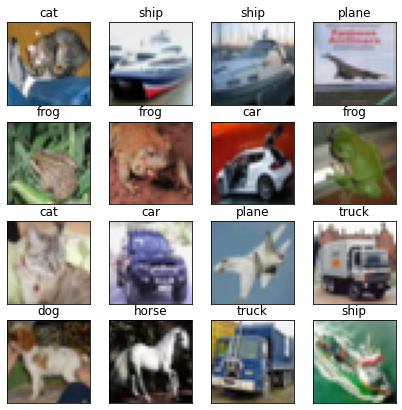

In [4]:
"""データの確認"""
cifar10 = CIFAR10(
    root="mydata", train=False, transform=transforms.ToTensor(), download=True
)
plt.figure(figsize=(7, 7))
chkimages, chklabels = iter(DataLoader(cifar10, batch_size=4 * 4)).next()
for i in range(4 * 4):
    plt.subplot(4, 4, i + 1)
    label = classes[chklabels[i]]
    plt.title(label)
    t_chkimages = np.transpose(chkimages[i], (1, 2, 0))
    plt.imshow(t_chkimages)
    plt.tick_params(
        labelbottom=False, labelleft=False, bottom=False, left=False
    )
plt.show()

In [5]:
"""モデルの定義"""


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(self.bn1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(self.bn2(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = CNN().to(device)
model

"""最適化手法の定義"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
"""訓練用の関数を定義"""


def train(train_loader):
    model.train()
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss / len(train_loader)
    return train_loss


"""評価用の関数を定義"""


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            correct += (
                predicted.eq(labels.view_as(predicted)).sum().item()
            )  # 先の例で説明済み
            total += labels.size(0)
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [7]:
%%time
"""誤差(loss)を記録する空の配列を用意"""
loss_list = []
val_loss_list = []
val_acc_list = []

"""学習"""
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print(
        "epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f"
        % (epoch, loss, val_loss, val_acc)
    )
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0, loss: 1.6290 val_loss: 1.4340 val_acc: 0.4863
epoch 1, loss: 1.4503 val_loss: 1.3348 val_acc: 0.5199
epoch 2, loss: 1.3812 val_loss: 1.3032 val_acc: 0.5341
epoch 3, loss: 1.3508 val_loss: 1.2603 val_acc: 0.5493
epoch 4, loss: 1.3201 val_loss: 1.2493 val_acc: 0.5513
epoch 5, loss: 1.2956 val_loss: 1.2083 val_acc: 0.5757
epoch 6, loss: 1.2740 val_loss: 1.1916 val_acc: 0.5784
epoch 7, loss: 1.2644 val_loss: 1.1993 val_acc: 0.5772
epoch 8, loss: 1.2457 val_loss: 1.1791 val_acc: 0.5810
epoch 9, loss: 1.2304 val_loss: 1.1519 val_acc: 0.5919
epoch 10, loss: 1.2190 val_loss: 1.1542 val_acc: 0.5854
epoch 11, loss: 1.2118 val_loss: 1.1612 val_acc: 0.5878
epoch 12, loss: 1.2052 val_loss: 1.1401 val_acc: 0.6003
epoch 13, loss: 1.1936 val_loss: 1.1278 val_acc: 0.6048
epoch 14, loss: 1.1849 val_loss: 1.1059 val_acc: 0.6081
epoch 15, loss: 1.1822 val_loss: 1.1098 val_acc: 0.6090
epoch 16, loss: 1.1673 val_loss: 1.0939 val_acc: 0.6122
epoch 17, loss: 1.1618 val_loss: 1.1067 val_acc: 0.6090
ep

In [8]:
"""学習の結果と使用したモデルを保存"""
np.save("loss_list.npy", np.array(loss_list))
np.save("val_loss_list.npy", np.array(val_loss_list))
np.save("val_acc_list.npy", np.array(val_acc_list))
torch.save(model.state_dict(), "cnn.pkl")

正解率： 64.11 %


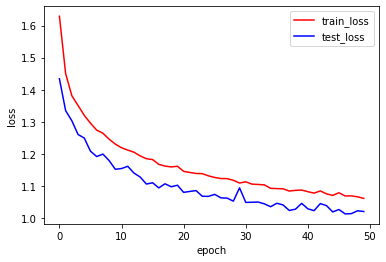

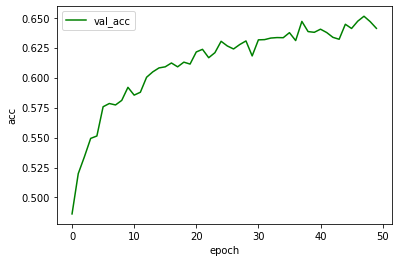

In [9]:
"""結果の表示"""
plt.plot(range(num_epochs), loss_list, "r-", label="train_loss")
plt.plot(range(num_epochs), val_loss_list, "b-", label="test_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.figure()

plt.plot(range(num_epochs), val_acc_list, "g-", label="val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")

print("正解率：", val_acc_list[-1] * 100, "%")

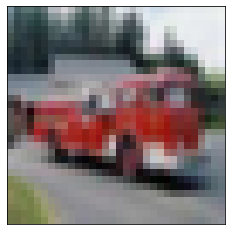

正解: truck 予測結果: ship


In [10]:
"""訓練済みモデルで精度を検証"""
images, labels = iter(DataLoader(cifar10, shuffle=True)).next()
img = np.transpose(images[0], (1, 2, 0))
plt.imshow(img)
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

lab = model(images.to(device))
print("正解:", classes[labels[0]], "予測結果:", classes[lab.argmax(1).item()])